<a href="https://colab.research.google.com/github/yatpor/NM-Project-3/blob/main/Project2timer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jacobi: Converged after 1786 iterations.
Time taken for Jacobi: 1.4111080169677734


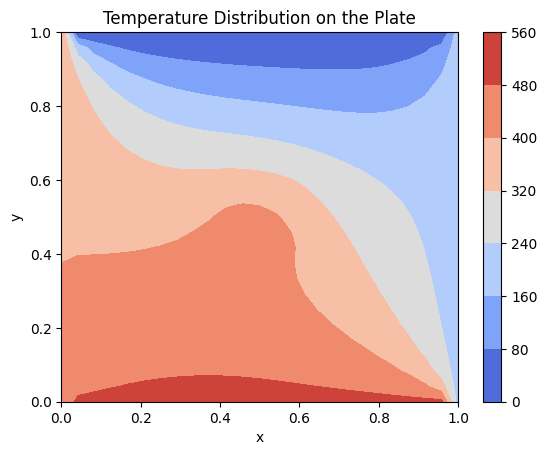

Gauss-Seidel: Converged after 931 iterations.
Time taken for Gauss Siedel: 0.7428524494171143


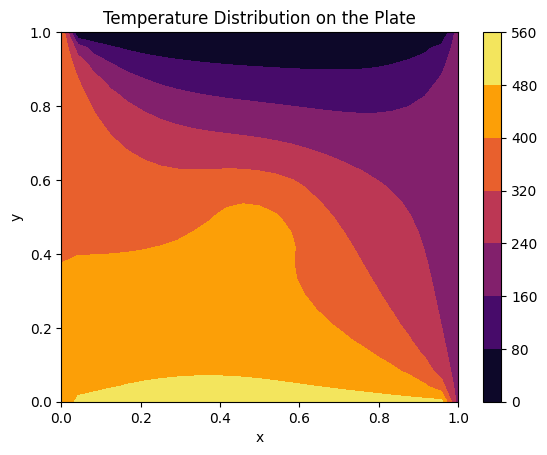

In [4]:
# NM Project - full matrix version
import numpy as np
import time
import matplotlib.pyplot as plt

# Define problem parameters
Lx, Ly = 1.0, 1.0  # Plate dimensions
Nx, Ny = 25, 25  # Number of grid points in x and y directions
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing

# Create a grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Initialize temperature field and heat source
T = np.zeros((Nx, Ny))  # Temperature
Q = np.zeros((Nx, Ny))  # Heat source (you can define your own)

# The region in the middle of the plate is a non-zero heat source
center_x = Nx // 2  # x-coordinate of the center
center_y = Ny // 2  # y-coordinate of the center
side_length = 5  # Size of the square region

# Set the heat source within the defined region
Q[center_x - side_length // 2: center_x + side_length // 2 + 1, center_y - side_length // 2: center_y + side_length // 2 + 1] = -10000.0  # Set source temperature

# Define boundary conditions (homogeneous Dirichlet)
T[0, :] = 500 # Heat applied at bottoom
T[-1, :] = 0  # Top
T[:, 0] = 400  # Left
T[:, -1] = 200  # Right

# Define convergence criteria
max_iterations = 100000
tolerance = 1e-6

# Jacobi Iteration
def jacobi_iteration(T, Q, dx, dy):
    Nx, Ny = T.shape
    T_new = np.copy(T)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T_new[i, j] = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1] - dx**2 * Q[i, j])
    return T_new

# Gauss-Seidel Iteration
def gauss_seidel_iteration(T, Q, dx, dy):
    Nx, Ny = T.shape
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T[i, j] = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1] - dx**2 * Q[i, j])
    return T

# Perform iterations until convergence (Jacobi method)
start_time = time.time()
for iteration in range(max_iterations):
    T_prev = np.copy(T)
    T = jacobi_iteration(T, Q, dx, dy)
    max_diff = np.max(np.abs(T - T_prev))
    if max_diff < tolerance:
        print(f"Jacobi: Converged after {iteration+1} iterations.")
        break
time_taken = time.time() - start_time
print(f'Time taken for Jacobi: {time_taken}')
# Visualize the temperature distribution
plt.contourf(x, y, T, cmap='coolwarm')
plt.colorbar()
plt.title("Temperature Distribution on the Plate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Reset T to zeros for Gauss-Seidel method
T = np.zeros((Nx, Ny))
T[0, :] = 500 # Heat applied at bottoom
T[-1, :] = 0  # Top
T[:, 0] = 400  # Left
T[:, -1] = 200  # Right

# Perform iterations until convergence (Gauss-Seidel method)
start_time = time.time()
for iteration in range(max_iterations):
    T_prev = np.copy(T)
    T = gauss_seidel_iteration(T, Q, dx, dy)
    max_diff = np.max(np.abs(T - T_prev))
    if max_diff < tolerance:
        print(f"Gauss-Seidel: Converged after {iteration+1} iterations.")
        break
time_taken = time.time() - start_time
print(f'Time taken for Gauss Siedel: {time_taken}')

# Visualize the temperature distribution
plt.contourf(x, y, T, cmap='inferno') # ='coolwarm')
plt.colorbar()
plt.title("Temperature Distribution on the Plate")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



Jacobi : Tolerance met at 1936 iterations
Time taken for Jacobi: 0.6831738948822021

Gauss Seidel: Tolerance met at 1014 iterations
Time taken for Gauss Siedel: 0.9904510974884033


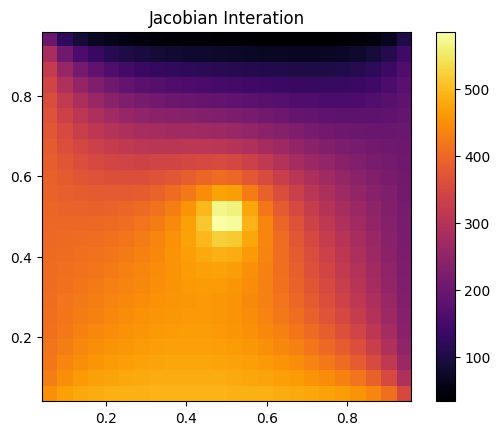

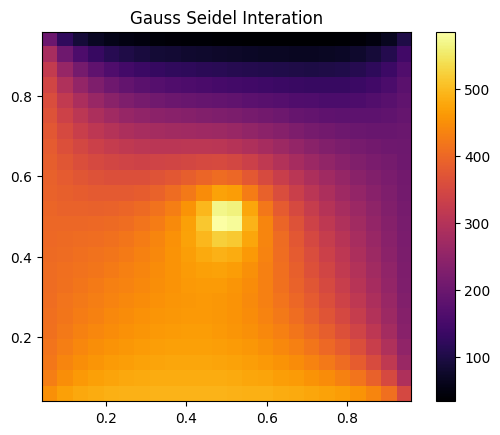

In [6]:
### Numerical Methods Group 3 Final Project ###


## Python package import (these packages must be installed for the script to run) ##

import sys
import time # with timers added
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import sparse
import scipy.sparse.linalg
np.set_printoptions(threshold=sys.maxsize)


## 2D Mesh Generation ##

x, y = np.meshgrid(np.linspace(0,1,25+1), np.linspace(0,1,25+1))    # Setting plate size and number of grid points
h = x[0][1] - x[0][0]       # Calculating grid spacing

## Internal Source ##

def f(x, y):

    if x> 0.45 and x<0.55 and y>0.45 and y<0.55: # If you are in small square at center of plate
        source = 100000     # Non-zero source specification

    else:
        source = 0          # Source everywhere else is zero

    return source

## Initial Conditions ##

T = np.zeros(((len(x)-2)*(len(y)-2), 1))    # Creating initial T matrix
T = sparse.csc_matrix(T)                    # Converting T to a sparse matrix (boosts solution efficiency)

## A Matrix Specification ##

A = np.zeros(((len(x)-2)*(len(y)-2), (len(x)-2)*(len(y)-2)))    # Creating initial A matrix

for row in range((len(x)-2)*(len(y)-2)):            # The following conditional statements populate the A matrix with the necessary values
    for column in range((len(x)-2)*(len(y)-2)):
        if column == row:       # Set diagonals
            A[row][column] = 4
        if column == row + 1:       # Consider temperature of node to the right
            A[row][column] = -1
            for i in range((len(x)-2)*(len(y)-2)):
                if column == i*(len(x)-2):      # Unless there is no node to the right
                    A[row][column] = 0
        elif column >= 0 and column == row - 1:     # Consider temperature of node to the left
            A[row][column] = -1
            for i in range((len(x)-2)*(len(y)-2)):
                if column == i*(len(x)-2)-1:        # Unless there is no node to the left
                    A[row][column] = 0
        elif column == row + len(x)-2:      # Consider temperature of node below
            A[row][column] = -1
            if row == max(range((len(x)-2)*(len(y)-2))):        # Unless there is no node below
                A[row][column] = 0
        elif column >= 0 and column == row - (len(x)-2):        # Consider temperature of node above
            A[row][column] = -1
            if row == 0:        # Unless there is no node above
                A[row][column] = 0

A = sparse.csc_matrix(A)        # Converting A matrix to a sparse matrix

## A matrix component breakdown ##

U = -1*sparse.triu(A, k=1)      # Breaking A matrix down into upper triangle (U), lower triangle (L), and diagonal (D) components
L = -1*sparse.tril(A, k=-1)
D = A + U + L
DmL = D-L

## RHS Matrix + Boundary Conditions ##

b = np.zeros(((len(x)-2)*(len(y)-2), 1))        # Creating initial rhs matrix (boundary conditions + source terms)

Top = 0        # Dirichlet boundary conditions for each wall
Bottom = 500
Left = 400
Right = 200

for i in range(len(b)):     # Populating rhs matrix with boundary conditions
    if i < len(x)-2:
        b[i][0] = Top       # Top boundary temp
    elif i >= (len(x)-2)*(len(y)-2)-len(x)+2:
        b[i][0] = Bottom       # Bottom boundary temp
    for j in range(len(x)-2):
        b[j*(len(x)-2)][0] = Left    # Left boundary temp
    for j in range(len(x)-2):
        b[j*(len(x)-2)-1][0] = Right  # Right boundary temp

for i in range(len(b)):         # Boundary condition corner correction
    if i==0:
        b[i][0] = Top+Left
    elif i == int(max(range(len(b)))):
        b[i][0] = Bottom+Right
    elif i == 0 + int((len(x)-2) -1):
        b[i][0] = Top+Right
    elif i == int(max(range(len(b)))) - int((len(x)-2) -1 ):
        b[i][0] = Bottom+Left

x_2 = []
for i in range(len(x)-2):
    x_2.append(x[i+1][1:-1])

y_2 = []
for i in range(len(y)-2):
    y_2.append(y[i+1][1:-1])

for i in range(len(y_2)):       # Applying internal source (with grid spacing consideration)
    for j in range(len(x_2)):
        b[i*(len(y_2))+j][0] += ((h**2) * f(x_2[i][j], y_2[i][j]))


## Solving for final T matrix ##

def Jloop(D, U, L, b, T, iterations):       # Jacobian iteration function

    Q = scipy.sparse.linalg.inv(D)@(L+U)      # Create T (named Q to avoid confusion with temperature)
    c = scipy.sparse.linalg.inv(D)@b          # Create c
    x_init = T      # Initialize temperature
    it = 0          # Initialize iteration count
    tolerance = 1e-6 # set tolerance to 1 x 10exp-6
    tolerance_met = 0

    while (it < iterations) and not(tolerance_met):      # Loop performing Jacobian iteration until specified iteration count is reached
        xnew = Q@x_init + c
        tolerance_met = all(np.abs(xnew-x_init) < tolerance)
        if tolerance_met: print(f'\nJacobi : Tolerance met at {it} iterations')
        x_init = xnew
        it += 1

    return xnew     # Returning final solution

def JGSloop(D, U, L, b, T, iterations):       # Gauss-Seidel iteration function

    Q = scipy.sparse.linalg.inv(DmL)@(U)      # Create T (named Q to avoid confusion with temperature)
    c = scipy.sparse.linalg.inv(DmL)@b          # Create c
    x_init = T      # Initialize temperature
    it = 0          # Initialize iteration count
    tolerance = 1e-6 # set tolerance to 1 x 10exp-6
    tolerance_met = 0



    while (it < iterations) and not(tolerance_met):      # Loop performing Gauss Seidel iteration until specified iteration count is reached
        xnew = Q@x_init + c
        tolerance_met = all(np.abs(xnew-x_init) < tolerance)
        if tolerance_met: print(f'\nGauss Seidel: Tolerance met at {it} iterations')
        x_init = xnew
        it += 1

    return xnew     # Returning final solution



# Main Programs

iterations = 20000      # iteration count specification (arbitary high number)

# Jacobi
start_time = time.time()
T = Jloop(D, U, L, b, T, iterations)        # Temperature solution
time_taken = time.time() - start_time
print(f'Time taken for Jacobi: {time_taken}')
## Plotting (Deactivate if using animation collection section) ##

T_plot = T.reshape((len(x)-2, len(y)-2))      # Reshaping T for contour plotting

fig, axs = plt.subplots()     # Creating figure
plt.title("Jacobian Interation")

axs.imshow(T_plot, cmap = plt.cm.inferno, vmin = np.ndarray.min(T), vmax = np.ndarray.max(T), extent = [x[0][1], x[-1][-2], y[1][0], y[-2][-1]])      # Generating contour
norm = mpl.colors.Normalize(vmin = np.ndarray.min(T), vmax = np.ndarray.max(T))
sm = plt.cm.ScalarMappable(norm=norm, cmap = plt.cm.inferno)
sm.set_array([])
fig.colorbar(ax = axs, mappable = sm)

plt.savefig(str(len(x)-1) + 'x' + str(len(y)-1)+' ('+str(iterations)+' iterations).png')      # Saving image to current working directory

# Gauss Seidel
# Reinitialize T
T = np.zeros(((len(x)-2)*(len(y)-2), 1))    # Creating initial T matrix
T = sparse.csc_matrix(T)                    # Converting T to a sparse matrix (boosts solution efficiency)

start_time = time.time()
T = JGSloop(D, U, L, b, T, iterations)        # Temperature solution
time_taken = time.time() - start_time
print(f'Time taken for Gauss Siedel: {time_taken}')

## Plotting (Deactivate if using animation collection section) ##

T_plot = T.reshape((len(x)-2, len(y)-2))      # Reshaping T for contour plotting

fig, axs = plt.subplots()     # Creating figure
plt.title("Gauss Seidel Interation")

axs.imshow(T_plot, cmap = plt.cm.inferno, vmin = np.ndarray.min(T), vmax = np.ndarray.max(T), extent = [x[0][1], x[-1][-2], y[1][0], y[-2][-1]])      # Generating contour
norm = mpl.colors.Normalize(vmin = np.ndarray.min(T), vmax = np.ndarray.max(T))
sm = plt.cm.ScalarMappable(norm=norm, cmap = plt.cm.inferno)
sm.set_array([])
fig.colorbar(ax = axs, mappable = sm)

plt.savefig(str(len(x)-1) + 'x' + str(len(y)-1)+' ('+str(iterations)+' iterations).png')      # Saving image to current working directory

## Animation image collection ##

# for i in range(iterations):        # Jacobian solution loop for animation creation (generates multiple images of solutions using different iteration counts)
#     iterations = i+1
#     T = np.zeros(((len(x)-2)*(len(y)-2), 1))    # Initializing T matrix
#     T = sparse.csc_matrix(T)
#     T = Jloop(D, U, L, b, T, iterations)        # Solving for T for current iteration count
#     T_plot = T.reshape((len(x)-2, len(y)-2))

#     fig, axs = plt.subplots()

#     axs.imshow(T_plot, cmap = plt.cm.inferno, vmin = np.ndarray.min(T), vmax = np.ndarray.max(T), extent = [x[0][1], x[-1][-2], y[0][1], y[-1][-2]])
#     norm = mpl.colors.Normalize(vmin = np.ndarray.min(T), vmax = np.ndarray.max(T))
#     sm = plt.cm.ScalarMappable(norm=norm, cmap = plt.cm.inferno)
#     sm.set_array([])
#     fig.colorbar(ax = axs, mappable = sm)

#     plt.savefig(str(len(x)-1) + 'x' + str(len(y)-1)+' ('+str(iterations)+' iterations).png')
#     plt.close(fig)

In [ ]:
import numpy as np
from scipy.sparse import diags, eye, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Define problem parameters
Lx, Ly = 1.0, 1.0  # Plate dimensions
Nx, Ny = 50, 50  # Number of grid points in x and y directions
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing

# Create a grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Initialize temperature field and heat source
T = np.zeros((Nx, Ny))  # Temperature
Q = np.zeros((Nx, Ny))  # Heat source

# Define the non-zero heat source at the center
center_x, center_y = Nx // 2, Ny // 2
Q[center_x, center_y] = -10000  # Adjust the heat source strength as needed

# Create a sparse matrix for the Poisson equation
# def create_poisson_matrix(Nx, Ny, dx, dy):
#     main_diag = -2 * (1 / dx**2 + 1 / dy**2) * np.ones(Nx * Ny)
#     off_diag = np.ones(Nx * Ny - 1) / dx**2
#     off_diag[Nx-1::Nx] = 0  # Remove elements corresponding to the periodic boundary in x
#     off_diag2 = np.ones(Nx * Ny - Nx) / dy**2

#     A = diags([main_diag, off_diag, off_diag, off_diag2, off_diag2], [0, -1, 1, -Nx, Nx], shape=(Nx * Ny, Nx * Ny))
#     return A

# A = create_poisson_matrix(Nx, Ny, dx, dy)

# # Apply Dirichlet boundary conditions
# def apply_dirichlet_bc(A, Nx, Ny):
#     # Set boundary rows and columns to identity
#     boundary_indices = np.concatenate([np.arange(0, Nx), np.arange(Nx*(Ny-1), Nx*Ny)])
#     A[boundary_indices, :] = 0
#     A[:, boundary_indices] = 0
#     A[boundary_indices, boundary_indices] = 1
#     return A

# A = apply_dirichlet_bc(A, Nx, Ny)

# Create a sparse matrix for the Poisson equation
def create_poisson_matrix(Nx, Ny, dx, dy):
    main_diag = -2 * (1 / dx**2 + 1 / dy**2) * np.ones(Nx * Ny)
    off_diag = np.ones(Nx * Ny - 1) / dx**2
    off_diag[Nx-1::Nx] = 0  # Remove elements corresponding to the periodic boundary in x
    off_diag2 = np.ones(Nx * Ny - Nx) / dy**2

    A = diags([main_diag, off_diag, off_diag, off_diag2, off_diag2], [0, -1, 1, -Nx, Nx], shape=(Nx * Ny, Nx * Ny))
    return A

A = create_poisson_matrix(Nx, Ny, dx, dy)

# Apply Dirichlet boundary conditions
def apply_dirichlet_bc(A, Nx, Ny):
    boundary_indices = np.concatenate([np.arange(0, Nx), np.arange(Nx*(Ny-1), Nx*Ny)])

    # Convert sparse matrix to dense for temporary modification
    A_dense = A.toarray()

    # Apply Dirichlet boundary conditions
    A_dense[boundary_indices, :] = 500
    A_dense[:, boundary_indices] = 0
    A_dense[boundary_indices, boundary_indices] = 1

    # Convert back to sparse matrix
    A = csr_matrix(A_dense)

    return A

A = apply_dirichlet_bc(A, Nx, Ny)

# Solve Poisson's equation using Jacobi method
def jacobi_iteration(A, T, Q, dx, dy):
    T_new = T.copy()
    T_flat = T_new.flatten()
    Q_flat = Q.flatten()

    for _ in range(1000):  # Adjust the number of iterations as needed
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                idx = i * Ny + j
                T_new[i, j] = 1 / A[idx, idx] * (Q_flat[idx] - A[idx, :].dot(T_flat))
        T_flat = T_new.flatten()

    return T_new

# Solve using Jacobi iteration
T_jacobi = jacobi_iteration(A, T, Q, dx, dy)

# Solve Poisson's equation using Gauss-Seidel method
def gauss_seidel_iteration(A, T, Q, dx, dy):
    T_flat = T.flatten()
    Q_flat = Q.flatten()

    for _ in range(1000):  # Adjust the number of iterations as needed
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                idx = i * Ny + j
                T_flat[idx] = 1 / A[idx, idx] * (Q_flat[idx] - A[idx, :].dot(T_flat))
    T_new = T_flat.reshape((Nx, Ny))

    return T_new

# Solve using Gauss-Seidel iteration
T_gauss_seidel = gauss_seidel_iteration(A, T, Q, dx, dy)

# Visualize the temperature distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, T_jacobi, cmap='coolwarm')
plt.colorbar()
plt.title("Temperature Distribution (Jacobi)")

plt.subplot(1, 2, 2)
plt.contourf(X, Y, T_gauss_seidel, cmap='coolwarm')
plt.colorbar()
plt.title("Temperature Distribution (Gauss-Seidel)")

plt.show()


KeyboardInterrupt: ignored

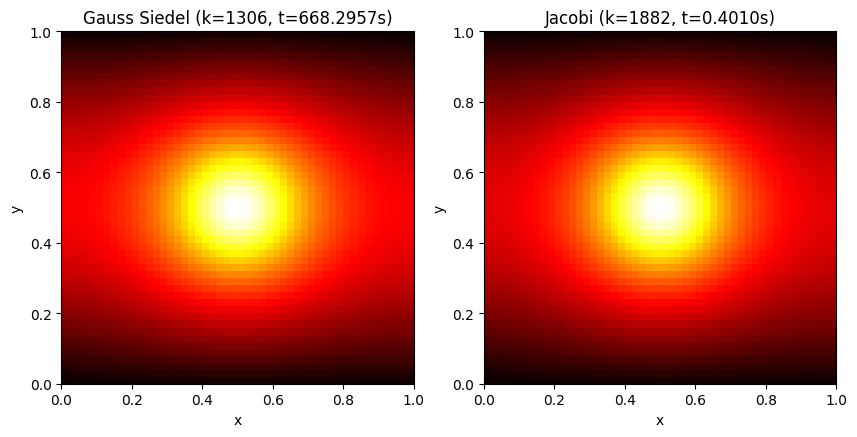

In [ ]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import time

def poisson_eqn(n, f):
    h = 1 / (n + 1)
    x = np.linspace(h, 1 - h, n)
    y = np.linspace(h, 1 - h, n)
    X, Y = np.meshgrid(x, y, indexing='ij')
    A = diags([-1, -1, 4, -1, -1], [-n, -1, 0, 1, n], shape=(n ** 2, n ** 2), format='csr') / h ** 2
    b = f(X, Y).ravel()
    return A, b

def gauss_siedel_sparse(A, b, x0, tol=1e-10, max_iter=100):
    n = A.shape[0]
    x = x0.copy()
    start_time = time.time()
    for k in range(max_iter):
        for i in range(n):
            s = A[i, :] @ x
            x[i] = (b[i] - s + A[i, i] * x[i]) / A[i, i]
        if np.allclose(x, x0, rtol=tol, atol=tol):
            end_time = time.time()
            return x, k, end_time - start_time
        x0 = x.copy()
    raise ValueError("Gauss Siedel failed to converge")

def jacobi_sparse(A, b, x0, tol=1e-10, max_iter=100):
    n = A.shape[0]
    x = x0.copy()
    start_time = time.time()
    for k in range(max_iter):
        x = (b - A @ x + A.diagonal() * x) / A.diagonal()
        if np.allclose(x, x0, rtol=tol, atol=tol):
            end_time = time.time()
            return x, k, end_time - start_time
        x0 = x.copy()
    raise ValueError("Jacobi failed to converge")

# Example usage
n = 50
f = lambda x, y: np.exp(-((x - 0.5) ** 2 + (y - 0.5) ** 2) / 0.1 ** 2)
A, b = poisson_eqn(n, f)
x0 = np.zeros(n ** 2)
tol = 1e-6
max_iter = 3000
x_gs, k_gs, t_gs = gauss_siedel_sparse(A, b, x0, tol=tol, max_iter=max_iter)
x_jacobi, k_jacobi, t_jacobi = jacobi_sparse(A, b, x0, tol=tol, max_iter=max_iter)

# Reshape the solution vector into a 2D array
T_gs = x_gs.reshape((n, n))
T_jacobi = x_jacobi.reshape((n, n))

# Plot the temperature distribution
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(T_gs, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
axs[0].set_title(f'Gauss Siedel (k={k_gs}, t={t_gs:.4f}s)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].imshow(T_jacobi, cmap='hot', origin='lower', extent=[0, 1, 0, 1])
axs[1].set_title(f'Jacobi (k={k_jacobi}, t={t_jacobi:.4f}s)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
plt.show()

